Interfacial tension =  0.46769746516074173 mN/m


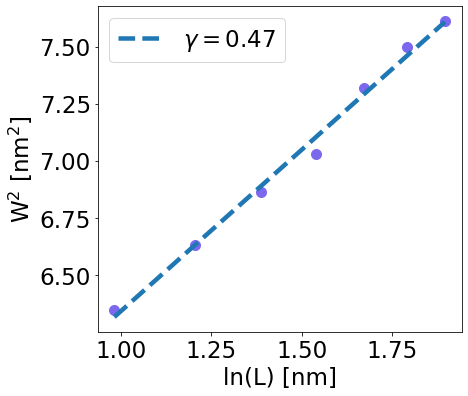

In [83]:
# Importing necessary libraries
import MDAnalysis as mda
from numpy.linalg import norm
import numpy as np
import pandas as pd
import sklearn.decomposition
import csv
from MDAnalysis.analysis.distances import distance_array
import freud
import os
import glob
from scipy.optimize import least_squares, curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler
from matplotlib.colors import LogNorm
import sys
import math
import matplotlib.pyplot as plt
import scipy.optimize as opt
import gsd.hoomd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def interfacial_tension_slab(lnL, W0, b, m):
    '''
    Slab Simulation of FUS Protein Condensates with an Adapted Coarse-Grained Model
    W0 - intrinsic width 
    lnL - log of slab thickness
    b - short-wavelength cutoff
    m - KB*T/(2*pi*gamma), where gamma is the interfacial tension
    Return : W - the interface width
    '''
    return W0**2 + m * (lnL - b)

# Function to compute interfacial tension (gamma) for slab systems
def gamma_slab(L, W2_data):
    '''
    Calculate the interfacial tension (gamma) for a slab system
    L - slab thickness 
    W2_data - squared interface width data
    '''
    L_data = np.log(L)
    initial_guess = [1, 1, 1]

    # Perform curve fitting 
    params, cov = curve_fit(interfacial_tension_slab, L_data, W2_data, p0=initial_guess)

    # Extract fit parameters
    W0_fit, b_fit, m_fit = params
    W0_err, b_err, m_err = [np.sqrt(cov[i][i]) for i in range(3)]

    # Generate fitted data
    L_fit = np.linspace(min(L_data), max(L_data), 100)
    W2_fit = interfacial_tension_slab(L_fit, W0_fit, b_fit, m_fit)

    # Calculate interfacial tension (gamma) from m
    KB = 1.380649e-23  # Boltzmann constant
    T = 300  # Temperature in Kelvin
    gamma_value = (KB * T) / (2 * np.pi * m_fit)  # Gamma in J/nm^2

    # Plotting the data and fit
    plt.figure(figsize=(7, 6))
    plt.plot(L_data, W2_data, 'o', ms=10, color='mediumslateblue')
    plt.plot(L_fit, W2_fit, '--', lw=4.5, label=r'$\gamma={:.2g}$'.format(gamma_value * 10**21))
    
    plt.xlabel(r'ln(L) [nm]')
    plt.ylabel(r'W$^2$ [nm$^2$]')
    plt.legend()
    plt.tight_layout()
    
    return gamma_value

# Loading data from file
list_width_avg = np.genfromtxt('width_ctd_pctd_hrd.txt')
gs = np.linspace(2, 8, 10)  # Slab thickness values
w2 = list_width_avg  # Squared interface width data

plt.rcParams.update({'font.size': 23})

# Calculate interfacial tension (gamma)
Gamma = gamma_slab(gs[1:-2], w2[1:-2])

print('Interfacial tension = ', Gamma * 10**21, 'mN/m')


In [7]:

import MDAnalysis as mda
from numpy.linalg import norm
import numpy as np
import pandas as pd
import sklearn.decomposition
import csv
from MDAnalysis.analysis.distances import distance_array
import freud
import os
import glob
from scipy.optimize import least_squares, curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler
from matplotlib.colors import LogNorm
import sys
import math
import matplotlib.pyplot as plt
import scipy.optimize as opt
import gsd.hoomd
from scipy import stats

# Parameters
bin_thickness = 0.5
use_max_density = 0
num_cm_iterations = 10
data_path = './'

# Load GSD file
trajectory = gsd.hoomd.open(name='traj_ctd_pctd_hrd.gsd', mode='rb+')
frame_start = 0

# Determine number of frames
num_frames = len(trajectory) - frame_start

# Box dimensions and particle masses
box_dimensions = trajectory[0].configuration.box
particle_masses = trajectory[0].particles.mass
screen_update_interval = max(1, int(num_frames / 20))

# Determine number and size of bins
histogram_volume = box_dimensions[0] * box_dimensions[1] * bin_thickness
num_bins = int(box_dimensions[2] / bin_thickness) + 1
bin_edges = np.linspace(-box_dimensions[2] / 2.0, box_dimensions[2] / 2.0, num=num_bins)

# Prepare histograms
monomer_position_distribution = []
monomer_cm_position_distribution = []

print('Number of frames:', num_frames)

def adjust_positions(positions, axis):
    initial_index = 0
    final_index = trajectory[0].particles.position.shape[0]
    
    # Compute density distribution of monomers
    monomer_position_distribution.append(
        np.histogram(positions[initial_index:final_index, axis],
                     bins=bin_edges,
                     weights=particle_masses[initial_index:final_index],
                     density=False)[0]
    )
    
    # Compute density distribution of monomers in CM frame
    if use_max_density:
        shifted_positions = positions[:]
        temp_distribution = np.histogram(shifted_positions[:, axis], bins=bin_edges, weights=particle_masses, density=False)[0]
        max_density_bin = np.argmax(temp_distribution)
        shifted_positions[:, axis] -= (max_density_bin * bin_thickness - box_dimensions[axis] / 2.0)
        shifted_positions[shifted_positions < -box_dimensions[axis] * 0.5] += box_dimensions[axis]
        shifted_positions[shifted_positions > box_dimensions[axis] * 0.5] -= box_dimensions[axis]
        
        cm = np.mean(shifted_positions, axis=0)
        shifted_positions -= cm
        shifted_positions[shifted_positions < -box_dimensions[axis] * 0.5] += box_dimensions[axis]
        shifted_positions[shifted_positions > box_dimensions[axis] * 0.5] -= box_dimensions[axis]
    else:
        shifted_positions = positions[:]
        for _ in range(num_cm_iterations):
            cm = np.mean(shifted_positions, axis=0)
            shifted_positions -= cm
            shifted_positions[shifted_positions < -box_dimensions[axis] * 0.5] += box_dimensions[axis]
            shifted_positions[shifted_positions > box_dimensions[axis] * 0.5] -= box_dimensions[axis]
    
    return shifted_positions

Lx, Ly, Lz = box_dimensions[:3]
lz = Lz
L = 15
edges = np.arange(-lz/2, lz/2, 1)
bin_thickness = (edges[1] - edges[0]) / 2.
z_values = edges[:-1] + bin_thickness
time_min = 0
time_max = num_frames
time_step = 1
num_time_steps = time_max - time_min

num_atoms = trajectory[0].particles.N
particle_positions = np.zeros((num_frames, num_atoms, 3))

frame_index = 0
for ts in range(frame_start, len(trajectory)):
    shifted_positions = adjust_positions(trajectory[ts].particles.position, 2)
    positions = shifted_positions[:]
    
    histogram = np.histogram(positions[:, 2], bins=edges)[0]
    particle_positions[frame_index][:] = positions
    
    frame_index += 1
position_particle_data = particle_positions




import matplotlib
matplotlib.rcParams.update({'font.size': 23})

def fitting_function(z, d, w, w0):
    return w0 * np.tanh((z - d) / w)

grid_sizes = np.linspace(2, 8, 10)

def calculate_error(data):
    return np.std(data) / np.sqrt(len(data))

position_particle_data = particle_positions
num_frames = position_particle_data.shape[0]
Lx, Ly, Lz = box_dimensions[:3]

grid_size_list = []
average_width_list = []
width_error_list = []


# Define number of chains and monomers
num_chains_ctd = 300
num_monomers_ctd = 140

num_chains_pctd = 100
num_monomers_pctd = 140

num_chains_hrd = 200
num_monomers_hrd = 71

# Recompute histograms with the updated bin_edges
histogram_ctd = np.apply_along_axis(
    lambda a: np.histogram(a, bins=bin_edges)[0], 
    1, 
    particle_positions[:, :num_chains_ctd * num_monomers_ctd, 2]
)

histogram_pctd = np.apply_along_axis(
    lambda a: np.histogram(a, bins=bin_edges)[0], 
    1, 
    particle_positions[:, num_chains_ctd * num_monomers_ctd:(num_chains_ctd * num_monomers_ctd + num_chains_pctd * num_monomers_pctd), 2]
)

histogram_hrd = np.apply_along_axis(
    lambda a: np.histogram(a, bins=bin_edges)[0], 
    1, 
    particle_positions[:, (num_chains_ctd * num_monomers_ctd + num_chains_pctd * num_monomers_pctd):(num_chains_ctd * num_monomers_ctd + num_chains_pctd * num_monomers_pctd + num_chains_hrd * num_monomers_hrd), 2]
)
# Assuming bin_edges corresponds to the histogram edges, make sure z_values aligns with these edges.
bin_edges = np.linspace(-Lz / 2, Lz / 2, num=len(np.mean(histogram_ctd[-1000:], axis=0) ) + 1)  # Define bin_edges based on histograms
z_values = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate z_values from bin edges

# Update conversion factors
conv_ctd = 10 / 6.022 / num_monomers_ctd / L / L * 1e3
conv_pctd = 10 / 6.022 / num_monomers_pctd / L / L * 1e3
conv_hrd = 10 / 6.022 / num_monomers_hrd / L / L * 1e3

# Compute mean histograms and apply conversion factor
mean_histogram_ctd = np.mean(histogram_ctd[-1000:], axis=0) * conv_ctd
mean_histogram_pctd = np.mean(histogram_pctd[-1000:], axis=0) * conv_pctd
mean_histogram_hrd = np.mean(histogram_hrd[-1000:], axis=0) * conv_hrd

# Plotting
plt.figure(figsize=(7, 4))
plt.plot(z_values, mean_histogram_pctd + mean_histogram_hrd, 'r', lw=3, label='pCTD-HRD')
plt.plot(z_values, mean_histogram_ctd, 'grey', lw=3, label='CTD')
plt.xlim(-75, 75)
plt.legend(fontsize=17)  # Set the legend fontsize to 17
plt.xlabel('z [nm]')
plt.ylabel('Density [mM]')
plt.tight_layout()

# Save the plot
plt.savefig('density_ctd_pctd_hrd.pdf')



for grid_size in grid_sizes:
    print(grid_size)
    
    grid_size_x = grid_size
    grid_size_y = grid_size

    num_grids_x = int(Lx / grid_size_x)
    num_grids_y = int(Ly / grid_size_y)

    num_chains_1 = 300
    num_monomers_1 = 140
    num_chains_2 = 100
    num_monomers_2 = 140
    num_chains_3 = 200
    num_monomers_3 = 71

    histogram_pctd = np.zeros((num_frames, edges.shape[0] - 1))
    histogram_ctd = np.zeros((num_frames, edges.shape[0] - 1))
    histogram_hrd = np.zeros((num_frames, edges.shape[0] - 1))
    
    histograms_1 = np.zeros((num_grids_x * num_grids_y, edges.shape[0] - 1))
    histograms_2 = np.zeros((num_grids_x * num_grids_y, edges.shape[0] - 1))
    histograms_3 = np.zeros((num_grids_x * num_grids_y, edges.shape[0] - 1))
    width_list = []

    for frame in range(num_frames):
        count = 0
        for i in range(num_grids_x):
            for j in range(num_grids_y):
                x_start = -Lx / 2 + i * grid_size_x
                x_end = x_start + grid_size_x
                y_start = -Ly / 2 + j * grid_size_y
                y_end = y_start + grid_size_y

                particles = position_particle_data[frame][:num_chains_1 * num_monomers_1]
                particles_in_grid_ctd = particles[(x_start <= particles[:, 0]) & (particles[:, 0] < x_end) &
                                                  (y_start <= particles[:, 1]) & (particles[:, 1] < y_end)]

                particles = position_particle_data[frame][num_chains_1 * num_monomers_1:num_chains_1 * num_monomers_1 + num_chains_2 * num_monomers_2]
                particles_in_grid_pctd = particles[(x_start <= particles[:, 0]) & (particles[:, 0] < x_end) &
                                                  (y_start <= particles[:, 1]) & (particles[:, 1] < y_end)]

                particles = position_particle_data[frame][num_chains_1 * num_monomers_1 + num_chains_2 * num_monomers_2:]
                particles_in_grid_hrd = particles[(x_start <= particles[:, 0]) & (particles[:, 0] < x_end) &
                                                  (y_start <= particles[:, 1]) & (particles[:, 1] < y_end)]

                histogram_ctd = np.histogram(particles_in_grid_ctd[:, 2], bins=edges)[0]
                histogram_pctd = np.histogram(particles_in_grid_pctd[:, 2], bins=edges)[0]
                histogram_hrd = np.histogram(particles_in_grid_hrd[:, 2], bins=edges)[0]
                
                count += 1
                z = edges[:-1] + bin_thickness
                try:
                    y = -(histogram_hrd + histogram_pctd - histogram_ctd) / (histogram_hrd + histogram_ctd + histogram_pctd)
                    valid_indices = ~np.isnan(y)
                    x = z[valid_indices]
                    y = y[valid_indices]
                    
                    x_values = np.linspace(-x.shape[0], 0, x.shape[0])
                    optimized_params_1, _ = opt.curve_fit(fitting_function, x_values, y)

                    y = -(histogram_hrd + histogram_pctd - histogram_ctd) / (histogram_hrd + histogram_ctd + histogram_pctd)
                    valid_indices = ~np.isnan(y)
                    x = z[valid_indices]
                    y = y[valid_indices]

                    x_values = np.linspace(0, x.shape[0], x.shape[0])
                    optimized_params_2, _ = opt.curve_fit(fitting_function, x_values, y)

                    if optimized_params_2[1] < 10 and optimized_params_1[1] < 10:
                        width_list.append(((optimized_params_1[1] + optimized_params_2[1]) * 0.5) ** 2)
                    
                except:
                    continue
        
    width_error_list.append(calculate_error(np.array(width_list)))
    average_width_list.append(np.array(width_list).mean())

np.savetxt('width_ctd_pctd_hrd.txt', average_width_list, fmt='%d', delimiter='\t')


Number of frames: 524
2.0


/home/achangia/.local/lib/python3.7/site-packages/ipykernel_launcher.py:183: RuntimeWarning: invalid value encountered in true_divide
/home/achangia/.local/lib/python3.7/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in true_divide


2.6666666666666665
3.333333333333333
4.0
4.666666666666666
5.333333333333333
6.0
6.666666666666666
7.333333333333333
8.0
